### XGBoost PIPELINE

In [1]:
import joblib
from datetime import datetime
import numpy as np
import os
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.data.database.mongodb import MongoDb
from backend.ml_pipe.models.xgboost.model import XGBoostModel

In [2]:
from backend.ml_pipe.data.database.mongodb import MongoDb
import pandas as pd
import matplotlib.pyplot as plt

def load_and_filter_labels_from_mongodb(
    user="florianrunkel",
    password="ur04mathesis",
    db_name="Database",
    collection="classification_dataset",
    show_plot=True
):

    # 1. Daten laden
    mongo_client = MongoDb(user=user, password=password, db_name=db_name)
    result = mongo_client.get_all(collection)
    raw_data = result.get('data', [])
    df = pd.DataFrame(raw_data)

    return df

def extract_xgb_features(features_dict):
    """
    Extrahiert flache Features aus dem Feature-Dictionary für XGBoost.
    Gibt eine Liste von numerischen Features zurück.
    """
    
    # Dictionary für die Branchen-Mapping
    branche_levels = {
        "bau": 1,
        "consulting": 2,
        "customerservice": 3,
        "design": 4,
        "education": 5,
        "einkauf": 6,
        "engineering": 7,
        "finance": 8,
        "freelance": 9,
        "gesundheit": 10,
        "healthcare": 11,
        "hr": 12,
        "immobilien": 13,
        "it": 14,
        "legal": 15,
        "logistik": 16,
        "marketing": 17,
        "medien": 18,
        "operations": 19,
        "produktion": 20,
        "projektmanagement": 21,
        "research": 22,
        "sales": 23,
        "verwaltung": 24
    }

    
    # Extrahiere und konvertiere die Features         
    return [
        features_dict.get("company_changes", 0),
        features_dict.get("total_experience_days", 0),
        features_dict.get("location_changes", 0),
        features_dict.get("average_days_per_position", 0),
        features_dict.get("position", 0),
        features_dict.get("highest_degree", 0),
        features_dict.get("position_level", 0),
        features_dict.get("duration_days", 0),
        branche_levels.get(features_dict.get("position_branche", ""), 0),
        features_dict.get("position_duration_days", 0),
        features_dict.get("age_category", 0)
    ]

Starte XGBoost-Pipeline...
Trainingsdaten: (36321, 11), Validierungsdaten: (15567, 11)
[INFO] Training XGBoost model...
[INFO] Training completed.
📊 Evaluationsergebnisse:
🔹 MSE : 0.178
🔹 MAE : 0.178
🔹 R²  : 0.290
Position-Kategorien gespeichert!
Modell gespeichert unter: saved_models/xgboost_model_20250605_164631.joblib
[INFO] Plotting feature importance...


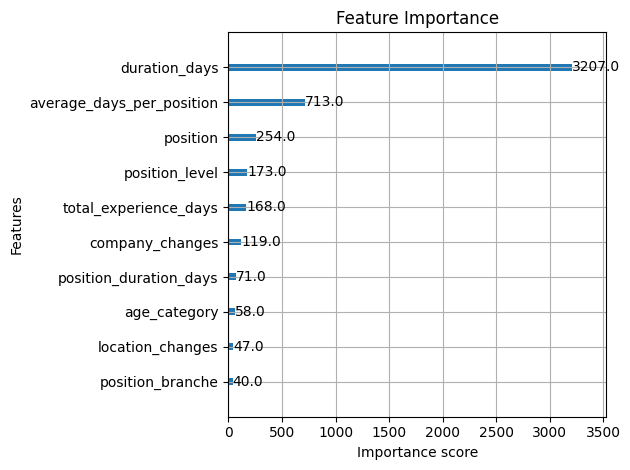

In [3]:
def run_xgboost_pipeline():
    print("Starte XGBoost-Pipeline...")

    df = load_and_filter_labels_from_mongodb()
    #print(df.head())
    feature_array = [extract_xgb_features(features) for features in df["features"]]
    X = pd.DataFrame(feature_array, columns=[
        "company_changes",
        "total_experience_days",
        "location_changes",
        "average_days_per_position",
        "position",
        "highest_degree",
        "position_level",
        "duration_days",
        "position_branche",
        "position_duration_days",
        "age_category"
    ])

    X["position"] = X["position"].astype("category")
    y = df["label"]

    # 3. Train/Test-Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}")

    # 4. Modell trainieren
    model = XGBoostModel()
    '''
    # Randomized Search
    best_params_random = model.randomized_search(X_train, y_train)
    score_random = model.model.best_score if hasattr(model.model, 'best_score') else None

    print("Beste Parameter (Randomized Search):", best_params_random, "Score:", score_random)


    best_params = best_params_random
    print("Nehme Randomized Search Parameter!")
    '''
    model.train(X_train, y_train)
    # 5. Modell evaluieren
    f1 = model.evaluate(X_val, y_val)

    # 6. Modell speichern mit Timestamp
    position_categories = list(X["position"].cat.categories)
    import joblib
    joblib.dump(position_categories, "/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/xgboost/saved_models/position_categories.pkl")
    print("Position-Kategorien gespeichert!")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"xgboost_model_{timestamp}.joblib")
    joblib.dump(model.model, model_path)
    print(f"Modell gespeichert unter: {model_path}")

    # 7. Optional: Feature Importance anzeigen
    try:
        model.plot_feature_importance()
    except Exception as e:
        print(f"Fehler beim Plotten der Feature-Wichtigkeit: {e}")

if __name__ == "__main__":
    run_xgboost_pipeline()

In [4]:
import sys
import json
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.models.xgboost.predict import predict

# LinkedIn Profildaten als Raw-String (beachte das 'r' vor dem String)
linkedin_data_str = r'''{"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}'''

try:
    # JSON-String in Dictionary umwandeln
    profile_data = json.loads(linkedin_data_str)
    
    # Vorhersage machen
    result = predict(profile_data)
    print("\nVorhersageergebnis:")
    print(f"Status: {result['status']}")
    print(f"Konfidenz: {result['confidence'][0]:.2%}")
    print("\nEmpfehlungen:")
    for rec in result['recommendations']:
        print(f"- {rec}")
    print("\nFeature-Wichtigkeiten:")
    for exp in result['explanations']:
        print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")

except json.JSONDecodeError as e:
    print(f"JSON Fehler: {str(e)}")
    print(f"Fehler an Position: {e.pos}")
    print(f"Zeile: {e.lineno}, Spalte: {e.colno}")

[DEBUG] Profile data parsed
[DEBUG] Career history found: 4 entries
[DEBUG] Last position: disponentin
[DEBUG] Features calculated: {'company_changes': 3, 'total_experience_days': 3409, 'location_changes': 1, 'average_days_per_position': 852, 'highest_degree': 1, 'position_level': 3, 'position_branche': 'logistik', 'duration_days': 821, 'position_duration_days': 900, 'age_category': 2}
[DEBUG] XGBoost Input Shape: (1, 11)
[DEBUG] XGBoost Input: [[3.000e+00 3.409e+03 1.000e+00 8.520e+02 1.000e+00 3.000e+00 0.000e+00
  1.600e+01 8.210e+02 9.000e+02 2.000e+00]]
[DEBUG] Probability: [0.84872395 0.15127604]

Vorhersageergebnis:
Status: likely to stay
Konfidenz: 15.13%

Empfehlungen:
- The candidate is likely to stay.
- Change probability: 15.1%

Feature-Wichtigkeiten:
- Current Position Duration (Days): 83.1% - Long duration suggests stability, short duration suggests willingness to change.
- Average Position Duration (Days): 6.0% - Average time spent in positions.
- Total Experience (Days)